# DG statistics compared to experimental values

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from  plotly import colors
import pandas as pd
import yaml
import pint
unit_registry = pint.UnitRegistry()

from tqdm.notebook import tqdm

from arsenic import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy

from PLBenchmarks import targets, ligands, edges
import benchmarkpl
path = benchmarkpl.__path__[0]
targets.set_data_dir(path)
results_dir = '10_results'

# Read in data

In [2]:
all_ligands = pd.read_csv("../03_comparison_experiment/03b_all_ligands_all_ffs.csv", index_col=0)
all_ligands.head()

,ligand,target,DG_Exp.,dDG_Exp.,DG_OpenFF-1.0,DG_OpenFF-1.0_converged,DG_OpenFF-1.2,DG_OpenFF-1.2_converged,DG_OpenFF-2.0,DG_OpenFF-2.0_converged,...,dDG_OpenFF-1.2,dDG_OpenFF-1.2_converged,dDG_OpenFF-2.0,dDG_OpenFF-2.0_converged,dDG_OPLS3e,dDG_GAFF2,dDG_cGenFF,dDG_Consensus_OpenFF_GAFF2_cGenFF,dDG_Consensus_OpenFF_GAFF2,dDG_Consensus_all
jnk1_lig_17124-1,17124-1,jnk1,-9.76,0.29,-10.498849,-10.410240,NaN,NaN,-11.647484,-11.641639,...,NaN,NaN,0.126579,0.127663,0.052150,0.193056,0.174543,0.245633,0.299317,0.103591
jnk1_lig_18631-1,18631-1,jnk1,-9.50,0.23,-9.208652,-9.114652,NaN,NaN,-9.480523,-9.474986,...,NaN,NaN,0.094876,0.096155,0.049214,0.402302,0.168230,0.325155,0.320194,0.127863
jnk1_lig_18634-1,18634-1,jnk1,-10.09,0.04,-10.098436,-10.020989,NaN,NaN,-11.048733,-11.048163,...,NaN,NaN,0.126496,0.127282,0.044415,0.132499,0.185769,0.223787,0.261344,0.093516
jnk1_lig_18626-1,18626-1,jnk1,-8.95,0.14,-8.185239,-8.133063,NaN,NaN,-8.077112,-8.077298,...,NaN,NaN,0.080243,0.081041,0.032254,0.107774,0.141012,0.165191,0.146609,0.066499
jnk1_lig_18624-1,18624-1,jnk1,-8.57,0.15,-7.995236,-7.936688,NaN,NaN,-7.067734,-7.068933,...,NaN,NaN,0.078940,0.079947,0.034820,0.116900,0.140377,0.178736,0.151406,0.068561


In [3]:
identifiers = [idx[3:] for idx in all_ligands if idx.startswith("DG")]
identifiers

['Exp.',
 'OpenFF-1.0',
 'OpenFF-1.0_converged',
 'OpenFF-1.2',
 'OpenFF-1.2_converged',
 'OpenFF-2.0',
 'OpenFF-2.0_converged',
 'OPLS3e',
 'GAFF2',
 'cGenFF',
 'Consensus_OpenFF_GAFF2_cGenFF',
 'Consensus_OpenFF_GAFF2',
 'Consensus_all']

In [4]:
def get_dg_statistics(df, idx=[], ref_idx='Exp.'):
    ligands_df = df[['ligand', 'target', f'DG_{ref_idx}', f'dDG_{ref_idx}'] + [f'DG_{i}' for i in idx] + [f'dDG_{i}' for i in idx]]
    ligands_df = ligands_df[~ligands_df.isna().any(axis=1)]
    statistics = ['RMSE','MUE', 'R2', 'KTAU', 'rho']
    result = {}
    for i in idx:
        print(i)
        name = i
        result[name] = {}
        result[name]['all'] = {}
        result[name]['all']['N'] = {'mle': ligands_df.shape[0]}
        for statistic in statistics:
            try:
                s = stats.bootstrap_statistic(
                ligands_df.loc[:,f'DG_{ref_idx}'], 
                ligands_df.loc[:,f'DG_{i}'], 
                statistic=statistic)
            except:
                print(ref_idx, i)
                print(ligands_df[f'DG_{i}'].isna().sum())
            result[name]['all'][statistic] = s
        for target in targets.target_dict:
            result[name][target] = {}
            if target in ligands_df['target'].values:
                result[name][target]['N'] = {'mle': ligands_df.loc[ligands_df['target']==target].shape[0]}
                for statistic in statistics:
                    s = stats.bootstrap_statistic(ligands_df.loc[ligands_df['target']==target,f'DG_{ref_idx}'], 
                                                  ligands_df.loc[ligands_df['target']==target,f'DG_{i}'], 
                                                  statistic=statistic)
                    result[name][target][statistic] = s
    df = pd.DataFrame.from_dict({(i,j,k): result[i][j][k] 
                           for i in result.keys() 
                           for j in result[i].keys()
                           for k in result[i][j].keys()},
                       orient='index')
    df.index.names = ['FF', 'set', f'statistic']
    return df

In [5]:
def bar_plot(df, statistic, ylabel=r'$\mathrm{RMSE\,[kcal\,mol^{-1}]}$', sets=[]):
    fig = go.Figure()
    if not len(sets):
        sets = df.index.get_level_values(0).unique()
    for name in sets:
        ddf = df.loc[np.invert(df['mle'].isna())]
        ddf = ddf.xs(name, level=0, axis=0)
        ddf = ddf.xs(statistic, level=1, axis=0)
        fig.add_trace(
            go.Bar(
                x = ddf.index,
                y = ddf['mle'],
                error_y=dict(
                type='data',
                symmetric=False,
                array=ddf['high']-ddf['mle'],
                arrayminus=ddf['mle']-ddf['low'],
                thickness=0.5,
                width=1,
                ),
                name=name
            )
        )
    fig.update_layout(
        template="simple_white",
        font_family="Helvetica",
        barmode='group',
        xaxis=dict(title='Target'),
        yaxis=dict(title=ylabel),
        margin=go.layout.Margin(
            l=0, #left margin
            r=0, #right margin
            b=0, #bottom margin
            t=0  #top margin
        ),
        legend=dict(
            orientation='h',
            yanchor="bottom",
            y=1.0,
            xanchor="left",
            x=0.00
        )
    )
    return fig

In [6]:
def write_table(df, name):
    table = {}
    for i, row in df.iterrows():
        if i[2] == 'N':
            df.loc[i, 'string'] = f"${int(row['mle'])}$"
        else:
            df.loc[i, 'string'] = f"${row['mle']:.1f}^{{{row['low']:.1f}}}_{{{row['high']:.1f}}}$"

    table_df = df.copy()
    table_df.index = df.index.swaplevel(i=0, j=2).swaplevel(i=1,j=2)
    table_df = table_df.string
    table_df = table_df.reset_index()
    table_df = table_df.pivot_table(columns=['statistic', 'FF'], index='set', values='string', aggfunc=''.join)
    n = table_df['N']
    table_df.drop('N', axis=1, inplace=True)
    table_df['N'] = n.iloc[:,0]
    table_df = table_df[['N', 'RMSE', 'MUE', 'R2', 'KTAU', 'rho']]
    table_df = table_df.reindex([
            'N',
            '',
            'OpenFF-1.0',
            'OpenFF-1.0_converged',
            'OpenFF-1.2',
            'OpenFF-1.2_converged',
            'OpenFF-2.0',
            'OpenFF-2.0_converged',
            'CGenFF/MATCH*',
            'GAFF2.1x',
            'OPLS3e',
            'Consensus',
            'Consensus (OFF, GAFF)',
            'Consensus (all)',
    ], axis=1, level=1)
    with open(f'{name}.tex', 'w') as file:
        file.write(table_df.to_latex())
    for statistic in ['RMSE', 'MUE', 'R2', 'KTAU', 'rho']:
        with open(f'{name}_{statistic}.tex', 'w') as file:
            file.write(table_df[['N', statistic]].to_latex(escape=False))
    return table_df

In [7]:
def get_significance( exp, predA, predB, alpha=0.05, bootnum=1000, bReturnDiff=False ):
    n = len(exp)
    errorA = np.power(exp-predA,2.0)
    errorB = np.power(exp-predB,2.0)
    diff = []
    for boot in range(0,bootnum):
        rand = np.random.choice(n, n, replace=True)
        foo_rmseA = np.sqrt( np.mean( errorA[rand] ))
        foo_rmseB = np.sqrt( np.mean( errorB[rand] ))
        foo_diff = foo_rmseA-foo_rmseB
        diff.append(foo_diff)



    diff = np.sort(diff)
    pos = np.shape( np.where( diff > 0.0 ) )[1]/float(bootnum)
    neg = np.shape( np.where( diff < 0.0 ) )[1]/float(bootnum)
    bSignif = False
    # more than 0.975 values are negative
    if pos < alpha/2.0:
        bSignif = True
    # more than 0.975 values are positive
    elif neg < alpha/2.0:
        bSignif = True
    if bReturnDiff:
        return(bSignif,diff)
    else:
        return(bSignif)

In [8]:
import scipy
def get_significance_ktau( exp, predA, predB, alpha=0.05, bootnum=1000, bReturnDiff=False ):
    #rmseA = np.sqrt( np.mean(np.power(exp-predA,2.0)))
    #rmseB = np.sqrt( np.mean(np.power(exp-predB,2.0)))
    n = len(exp)
    diff = []
    for boot in range(0,bootnum):
        rand = np.random.choice(n, n, replace=True)
        foo_ktauA, pA = scipy.stats.kendalltau(exp[rand], predA[rand])
        foo_ktauB, pB = scipy.stats.kendalltau(exp[rand], predB[rand])
        foo_diff = foo_ktauA-foo_ktauB
        diff.append(foo_diff)



    diff = np.sort(diff)
    pos = np.shape( np.where( diff > 0.0 ) )[1]/float(bootnum)
    neg = np.shape( np.where( diff < 0.0 ) )[1]/float(bootnum)
    bSignif = False
    # more than 0.975 values are negative
    if pos < alpha/2.0:
        bSignif = True
    # more than 0.975 values are positive
    elif neg < alpha/2.0:
        bSignif = True
    if bReturnDiff:
        return(bSignif,diff)
    else:
        return(bSignif)
#

In [9]:
identifiers

['Exp.',
 'OpenFF-1.0',
 'OpenFF-1.0_converged',
 'OpenFF-1.2',
 'OpenFF-1.2_converged',
 'OpenFF-2.0',
 'OpenFF-2.0_converged',
 'OPLS3e',
 'GAFF2',
 'cGenFF',
 'Consensus_OpenFF_GAFF2_cGenFF',
 'Consensus_OpenFF_GAFF2',
 'Consensus_all']

In [10]:
df_off = get_dg_statistics(all_ligands, 
                           idx=[
                            'OpenFF-1.0',
                            'OpenFF-1.2',
                            'OpenFF-2.0'
                            ]
                            )
df_off.rename({'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)", 
                 'Consensus_all': "Consensus (all)",
                 "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
                 "GAFF2": "GAFF2.1x",
                 "cGenFF": "CGenFF/MATCH*"}, axis=0, level=0, inplace=True)
df_off.rename({x: x.upper() for x in df_off.index.get_level_values(1)}, axis=0, level=1, inplace=True)
df_off.rename({'BACE_HUNT': "BACE (HUNT)", 
                     'BACE_P2': "BACE (P2)"}, axis=0, level=1, inplace=True)
for statistic in ['RMSE', 'MUE', 'R2', 'KTAU', 'rho']:
    if statistic in ['RMSE', 'MUE']:
        ylabel=r"$\mathrm{" + statistic + "(\Delta G)\,[kcal\,mol^{-1}]}$"
    else:
        if statistic == "rho":
            statisticname="\rho"
        elif statistic == "KTAU":
            statisticname=r"$\tau_{\mathrm{K}}"
        else:
            statisticname=r"$\mathrm{" + statistic + "}"
        ylabel=statisticname+"(\Delta G)$"
    fig = bar_plot(df_off, statistic, ylabel=ylabel)
    fig.write_image(f'04b_bar_dg_{statistic}_openff_versions.png')
df_off.to_csv('04b_openff_versions_dg.csv')
write_table(df_off, '04b_openff_versions_dg')

OpenFF-1.0
OpenFF-1.2
OpenFF-2.0


statistic      N               RMSE                                        \
FF                       OpenFF-1.0         OpenFF-1.2         OpenFF-2.0   
set                                                                         
ALL        $264$  $1.4^{1.2}_{1.5}$  $1.5^{1.3}_{1.6}$  $1.3^{1.2}_{1.4}$   
CDK8        $33$  $1.1^{0.9}_{1.4}$  $1.1^{0.9}_{1.2}$  $1.3^{1.1}_{1.4}$   
CMET        $24$  $1.0^{0.7}_{1.3}$  $1.4^{1.1}_{2.0}$  $1.4^{1.1}_{1.7}$   
EG5         $28$  $1.4^{0.8}_{1.8}$  $1.4^{1.0}_{1.9}$  $0.9^{0.6}_{1.0}$   
HIF2A       $42$  $1.8^{1.5}_{2.1}$  $1.7^{1.3}_{2.0}$  $1.6^{1.3}_{1.9}$   
PFKFB3      $40$  $1.4^{1.1}_{1.6}$  $1.4^{1.2}_{1.6}$  $1.1^{0.9}_{1.3}$   
SHP2        $26$  $1.8^{1.3}_{2.3}$  $1.8^{1.3}_{2.3}$  $1.7^{1.4}_{2.1}$   
SYK         $44$  $1.0^{0.9}_{1.3}$  $1.4^{1.2}_{1.7}$  $1.4^{1.1}_{1.7}$   
TNKS2       $27$  $1.0^{0.8}_{1.3}$  $1.1^{0.8}_{1.3}$  $1.1^{0.8}_{1.3}$   

statistic                MUE                                        \
FF                OpenFF-1.0         OpenFF-1.2         OpenFF-2.0   
set                                                                  
ALL        $1.1^{1.0}_{1.2}$  $1.1^{1.0}_{1.2}$  $1.1^{1.0}_{1.2}$   
CDK8       $0.9^{0.7}_{1.1}$  $0.8^{0.7}_{1.1}$  $1.1^{0.9}_{1.3}$   
CMET       $0.8^{0.6}_{1.1}$  $1.1^{0.9}_{1.6}$  $1.1^{0.8}_{1.5}$   
EG5        $0.9^{0.6}_{1.3}$  $1.0^{0.8}_{1.4}$  $0.7^{0.5}_{0.8}$   
HIF2A      $1.5^{1.2}_{1.8}$  $1.2^{0.9}_{1.6}$  $1.2^{0.9}_{1.6}$   
PFKFB3     $1.2^{0.9}_{1.4}$  $1.2^{1.0}_{1.4}$  $0.9^{0.7}_{1.1}$   
SHP2       $1.3^{1.0}_{1.9}$  $1.4^{1.0}_{1.9}$  $1.6^{1.2}_{1.9}$   
SYK        $0.9^{0.7}_{1.1}$  $1.2^{1.0}_{1.5}$  $1.1^{0.8}_{1.4}$   
TNKS2      $0.8^{0.6}_{1.1}$  $0.8^{0.6}_{1.1}$  $0.8^{0.6}_{1.1}$   

statistic                 R2                                        \
FF                OpenFF-1.0         OpenFF-1.2         OpenFF-2.0   
set                                                                  
ALL        $0.5^{0.4}_{0.5}$  $0.5^{0.4}_{0.6}$  $0.5^{0.4}_{0.6}$   
CDK8       $0.6^{0.5}_{0.8}$  $0.7^{0.6}_{0.8}$  $0.5^{0.4}_{0.7}$   
CMET       $0.8^{0.5}_{0.9}$  $0.9^{0.5}_{0.9}$  $0.8^{0.5}_{0.9}$   
EG5        $0.2^{0.1}_{0.5}$  $0.2^{0.1}_{0.4}$  $0.4^{0.1}_{0.7}$   
HIF2A      $0.2^{0.1}_{0.5}$  $0.2^{0.0}_{0.4}$  $0.2^{0.0}_{0.5}$   
PFKFB3     $0.2^{0.1}_{0.5}$  $0.3^{0.1}_{0.5}$  $0.5^{0.3}_{0.7}$   
SHP2       $0.0^{0.0}_{0.4}$  $0.0^{0.0}_{0.4}$  $0.0^{0.0}_{0.3}$   
SYK        $0.3^{0.0}_{0.5}$  $0.3^{0.0}_{0.5}$  $0.3^{0.1}_{0.6}$   
TNKS2      $0.2^{0.1}_{0.6}$  $0.3^{0.0}_{0.6}$  $0.3^{0.0}_{0.6}$   

statistic                KTAU                                          \
FF                 OpenFF-1.0          OpenFF-1.2          OpenFF-2.0   
set                                                                     
ALL         $0.5^{0.4}_{0.5}$   $0.5^{0.5}_{0.6}$   $0.5^{0.5}_{0.6}$   
CDK8        $0.7^{0.5}_{0.8}$   $0.7^{0.5}_{0.8}$   $0.6^{0.5}_{0.7}$   
CMET        $0.7^{0.5}_{0.8}$   $0.7^{0.5}_{0.9}$   $0.7^{0.5}_{0.9}$   
EG5         $0.3^{0.1}_{0.5}$   $0.3^{0.1}_{0.6}$   $0.4^{0.2}_{0.6}$   
HIF2A       $0.2^{0.0}_{0.4}$   $0.3^{0.1}_{0.5}$   $0.3^{0.2}_{0.5}$   
PFKFB3      $0.3^{0.1}_{0.5}$   $0.4^{0.2}_{0.5}$   $0.5^{0.3}_{0.7}$   
SHP2       $0.1^{-0.2}_{0.5}$  $0.2^{-0.2}_{0.5}$  $0.1^{-0.2}_{0.4}$   
SYK         $0.3^{0.1}_{0.4}$   $0.3^{0.1}_{0.5}$   $0.4^{0.2}_{0.6}$   
TNKS2       $0.5^{0.1}_{0.6}$  $0.3^{-0.0}_{0.5}$   $0.4^{0.0}_{0.5}$   

statistic                 rho                                          
FF                 OpenFF-1.0          OpenFF-1.2          OpenFF-2.0  
set                                                                    
ALL         $0.7^{0.6}_{0.7}$   $0.7^{0.6}_{0.7}$   $0.7^{0.7}_{0.8}$  
CDK8        $0.8^{0.7}_{0.9}$   $0.8^{0.7}_{0.9}$   $0.7^{0.6}_{0.8}$  
CMET        $0.9^{0.7}_{1.0}$   $1.0^{0.7}_{1.0}$   $0.9^{0.7}_{1.0}$  
EG5         $0.5^{0.2}_{0.7}$   $0.5^{0.2}_{0.7}$   $0.7^{0.4}_{0.8}$  
HIF2A       

In [11]:
df_off_converged = get_dg_statistics(all_ligands, idx=[
 'OpenFF-1.0_converged',
 'OpenFF-1.2_converged',
 'OpenFF-2.0_converged'])
df_off_converged.rename({'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)", 
                 'Consensus_all': "Consensus (all)",
                 "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
                 "GAFF2": "GAFF2.1x",
                 "cGenFF": "CGenFF/MATCH*"}, axis=0, level=0, inplace=True)
df_off_converged.rename({x: x.upper() for x in df_off_converged.index.get_level_values(1)}, axis=0, level=1, inplace=True)
df_off_converged.rename({'BACE_HUNT': "BACE (HUNT)", 
                     'BACE_P2': "BACE (P2)"}, axis=0, level=1, inplace=True)
for statistic in ['RMSE', 'MUE', 'R2', 'KTAU', 'rho']:    
    if statistic in ['RMSE', 'MUE']:
        ylabel=r"$\mathrm{" + statistic + "(\Delta G)\,[kcal\,mol^{-1}]}$"
    else:
        if statistic == "rho":
            statisticname="\rho"
        elif statistic == "KTAU":
            statisticname=r"$\tau_{\mathrm{K}}"
        else:
            statisticname=r"$\mathrm{" + statistic + "}"
        ylabel=statisticname+"(\Delta G)$"
    fig = bar_plot(df_off_converged, statistic, ylabel=ylabel)
    fig.write_image(f'04b_bar_dg_{statistic}_openff_repeatfilter_versions.png')
df_off_converged.to_csv('04b_openff_versions_dg.csv')
write_table(df_off_converged, '04b_openff_repeatfilter_versions_dg')

OpenFF-1.0_converged
OpenFF-1.2_converged
OpenFF-2.0_converged


statistic      N                 RMSE                       \
FF               OpenFF-1.0_converged OpenFF-1.2_converged   
set                                                          
ALL        $150$    $1.3^{1.1}_{1.4}$    $1.4^{1.2}_{1.5}$   
CDK8        $27$    $1.2^{0.9}_{1.4}$    $1.2^{0.9}_{1.4}$   
CMET        $24$    $1.0^{0.7}_{1.4}$    $1.3^{1.0}_{1.8}$   
HIF2A       $37$    $1.6^{1.4}_{1.9}$    $1.5^{1.2}_{1.9}$   
PFKFB3      $35$    $1.4^{1.1}_{1.6}$    $1.4^{1.2}_{1.7}$   
TNKS2       $27$    $0.9^{0.7}_{1.1}$    $1.1^{0.8}_{1.3}$   

statistic                                       MUE                       \
FF        OpenFF-2.0_converged OpenFF-1.0_converged OpenFF-1.2_converged   
set                                                                        
ALL          $1.3^{1.1}_{1.4}$    $1.0^{0.9}_{1.2}$    $1.1^{1.0}_{1.2}$   
CDK8         $1.3^{1.1}_{1.6}$    $1.0^{0.7}_{1.2}$    $1.0^{0.8}_{1.2}$   
CMET         $1.2^{0.9}_{1.5}$    $0.8^{0.5}_{1.1}$    $1.1^{0.8}_{1.5}$   
HIF2A        $1.6^{1.2}_{1.9}$    $1.4^{1.1}_{1.7}$    $1.2^{0.8}_{1.5}$   
PFKFB3       $1.1^{0.9}_{1.3}$    $1.1^{0.9}_{1.4}$    $1.3^{1.0}_{1.5}$   
TNKS2        $1.0^{0.8}_{1.2}$    $0.7^{0.5}_{0.9}$    $0.9^{0.6}_{1.1}$   

statistic                                        R2                       \
FF        OpenFF-2.0_converged OpenFF-1.0_converged OpenFF-1.2_converged   
set                                                                        
ALL          $1.0^{0.9}_{1.2}$    $0.5^{0.4}_{0.6}$    $0.5^{0.4}_{0.6}$   
CDK8         $1.2^{0.9}_{1.4}$    $0.6^{0.4}_{0.8}$    $0.5^{0.3}_{0.7}$   
CMET         $0.9^{0.7}_{1.3}$    $0.7^{0.4}_{0.9}$    $0.9^{0.5}_{0.9}$   
HIF2A        $1.2^{0.9}_{1.6}$    $0.3^{0.0}_{0.5}$    $0.3^{0.0}_{0.5}$   
PFKFB3       $0.9^{0.8}_{1.1}$    $0.2^{0.0}_{0.4}$    $0.3^{0.1}_{0.5}$   
TNKS2        $0.8^{0.6}_{1.1}$    $0.5^{0.2}_{0.7}$    $0.1^{0.0}_{0.5}$   

statistic                                      KTAU                       \
FF        OpenFF-2.0_converged OpenFF-1.0_converged OpenFF-1.2_converged   
set                                                                        
ALL          $0.6^{0.4}_{0.6}$    $0.5^{0.4}_{0.6}$    $0.5^{0.4}_{0.6}$   
CDK8         $0.5^{0.3}_{0.7}$    $0.7^{0.4}_{0.8}$    $0.6^{0.3}_{0.8}$   
CMET         $0.8^{0.6}_{0.9}$    $0.6^{0.4}_{0.8}$    $0.8^{0.5}_{0.9}$   
HIF2A        $0.2^{0.0}_{0.5}$   $0.2^{-0.1}_{0.4}$    $0.4^{0.1}_{0.5}$   
PFKFB3       $0.5^{0.2}_{0.6}$    $0.2^{0.0}_{0.5}$    $0.4^{0.2}_{0.6}$   
TNKS2        $0.3^{0.0}_{0.6}$    $0.5^{0.2}_{0.6}$   $0.3^{-0.0}_{0.5}$   

statistic                                       rho                       \
FF        OpenFF-2.0_converged OpenFF-1.0_converged OpenFF-1.2_converged   
set                                                                        
ALL          $0.5^{0.5}_{0.6}$    $0.7^{0.6}_{0.8}$    $0.7^{0.6}_{0.8}$   
CDK8         $0.6^{0.3}_{0.7}$    $0.8^{0.6}_{0.9}$    $0.8^{0.6}_{0.9}$   
CMET         $0.7^{0.5}_{0.9}$    $0.9^{0.7}_{0.9}$    $1.0^{0.7}_{1.0}$   
HIF2A        $0.3^{0.1}_{0.5}$    $0.5^{0.2}_{0.7}$    $0.5^{0.2}_{0.7}$   
PFKFB3       $0.5^{0.3}_{0.6}$    $0.4^{0.2}_{0.6}$    $0.6^{0.3}_{0.7}$   
TNKS2        $0.3^{0.0}_{0.6}$    $0.7^{0.4}_{0.8}$    $0.6^{0.1}_{0.8}$   

statistic                       
FF        OpenFF-2.0_converged  
set                             
ALL          $0.7^{0.7}_{0.8}$  
CDK8         $0.7^{0.5}_{0.9}$  
CMET         $0.9^{0.8}_{1.0}$  
HIF2A        $0.5^{0.2}_{0.7}$  
PFKFB3       $0.7^{0.5}_{0.8}$  
TNKS2        $0.6^{0.2}_{0.8}$

In [12]:
df_all = get_dg_statistics(all_ligands, idx=[
                            'OpenFF-1.0',
                            'OpenFF-2.0',
                            'OPLS3e',
                            'GAFF2',
                            'cGenFF', 
                            'Consensus_OpenFF_GAFF2_cGenFF',
                            'Consensus_OpenFF_GAFF2',
                            'Consensus_all',
                            ]
                          )
df_all.rename({'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)", 
                 'Consensus_all': "Consensus (all)",
                 "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
                 "GAFF2": "GAFF2.1x",
                 "cGenFF": "CGenFF/MATCH*"}, axis=0, level=0, inplace=True)
df_all.rename({x: x.upper() for x in df_all.index.get_level_values(1)}, axis=0, level=1, inplace=True)
df_all.rename({'BACE_HUNT': "BACE (HUNT)", 
                     'BACE_P2': "BACE (P2)"}, axis=0, level=1, inplace=True)
for statistic in ['RMSE', 'MUE', 'R2', 'KTAU', 'rho']:    
    if statistic in ['RMSE', 'MUE']:
        ylabel=r"$\mathrm{" + statistic + "(\Delta G)\,[kcal\,mol^{-1}]}$"
    else:        
        if statistic == "rho":
            statisticname="\rho"
        elif statistic == "KTAU":
            statisticname=r"$\tau_{\mathrm{K}}"
        else:
            statisticname=r"$\mathrm{" + statistic + "}"
        ylabel=statisticname+"(\Delta G)$"
    fig = bar_plot(df_all, statistic, ylabel=ylabel)
    fig.write_image(f'04b_bar_dg_{statistic}_ff.png', width=800, height=400, scale=2)

OpenFF-1.0
OpenFF-2.0
OPLS3e
GAFF2
cGenFF
Consensus_OpenFF_GAFF2_cGenFF
Consensus_OpenFF_GAFF2
Consensus_all


In [13]:
write_table(df_all, '04b_ff_dg')

/home/dhahn3/miniconda3/envs/off/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3029: PerformanceWarning:

indexing past lexsort depth may impact performance.



statistic        N               RMSE                                        \
FF                         OpenFF-1.0         OpenFF-2.0      CGenFF/MATCH*   
set                                                                           
ALL          $598$  $1.3^{1.2}_{1.3}$  $1.3^{1.2}_{1.4}$  $1.4^{1.3}_{1.5}$   
BACE          $36$  $0.9^{0.7}_{1.0}$  $0.8^{0.7}_{0.9}$  $1.0^{0.7}_{1.3}$   
BACE (HUNT)   $32$  $0.8^{0.6}_{1.0}$  $0.8^{0.7}_{1.0}$  $1.1^{0.8}_{1.3}$   
BACE (P2)     $12$  $0.8^{0.5}_{1.1}$  $0.7^{0.5}_{1.0}$  $0.7^{0.6}_{0.9}$   
CDK2          $16$  $0.6^{0.4}_{0.9}$  $0.7^{0.5}_{1.0}$  $1.0^{0.7}_{1.3}$   
CDK8          $33$  $1.1^{0.9}_{1.3}$  $1.2^{1.1}_{1.5}$  $1.5^{1.1}_{1.7}$   
CMET          $24$  $1.0^{0.7}_{1.3}$  $1.4^{1.1}_{1.7}$  $1.0^{0.6}_{1.5}$   
EG5           $28$  $1.4^{0.8}_{1.8}$  $0.8^{0.6}_{1.0}$  $1.5^{1.0}_{2.0}$   
GALECTIN       $8$  $0.9^{0.6}_{1.1}$  $0.6^{0.4}_{0.7}$  $0.3^{0.2}_{0.4}$   
HIF2A         $42$  $1.8^{1.5}_{2.1}$  $1.6^{1.3}_{1.9}$  $2.6^{2.1}_{3.1}$   
JNK1          $21$  $0.9^{0.6}_{1.1}$  $1.2^{1.0}_{1.3}$  $0.8^{0.4}_{1.0}$   
MCL1          $42$  $1.2^{1.0}_{1.5}$  $1.0^{0.8}_{1.3}$  $1.4^{1.1}_{1.6}$   
P38           $34$  $1.1^{0.8}_{1.5}$  $0.8^{0.6}_{1.0}$  $1.2^{0.9}_{1.6}$   
PDE10         $34$  $1.6^{1.4}_{2.0}$  $2.6^{2.2}_{3.0}$  $1.6^{1.3}_{1.8}$   
PDE2          $21$  $1.4^{1.1}_{1.7}$  $1.2^{1.0}_{1.4}$  $1.2^{0.9}_{1.5}$   
PFKFB3        $40$  $1.4^{1.1}_{1.6}$  $1.1^{0.9}_{1.3}$  $1.5^{1.2}_{1.7}$   
PTP1B         $23$  $1.3^{0.8}_{1.8}$  $1.4^{0.7}_{1.9}$  $1.1^{0.5}_{1.6}$   
ROS1          $28$  $1.4^{1.1}_{1.8}$  $1.2^{0.8}_{1.6}$  $0.8^{0.5}_{1.1}$   
SHP2          $26$  $1.7^{1.3}_{2.3}$  $1.8^{1.4}_{2.1}$  $1.3^{1.1}_{1.6}$   
SYK           $44$  $1.1^{0.9}_{1.2}$  $1.4^{1.1}_{1.7}$  $1.0^{0.8}_{1.2}$   
THROMBIN      $11$  $0.8^{0.5}_{1.0}$  $0.7^{0.5}_{1.0}$  $1.0^{0.3}_{1.7}$   
TNKS2         $27$  $1.0^{0.8}_{1.3}$  $1.1^{0.8}_{1.2}$  $1.7^{1.3}_{2.1}$   
TYK2          $16$  $0.8^{0.5}_{1.0}$  $0.7^{0.5}_{0.9}$  $1.2^{0.9}_{1.3}$   

statistic                                                             \
FF                    GAFF2.1x             OPLS3e          Consensus   
set                                                                    
ALL          $1.2^{1.1}_{1.3}$  $1.2^{1.1}_{1.3}$  $1.1^{1.0}_{1.2}$   
BACE         $0.9^{0.7}_{1.1}$  $1.0^{0.8}_{1.3}$  $0.8^{0.6}_{0.9}$   
BACE (HUNT)  $0.9^{0.7}_{1.1}$  $0.7^{0.5}_{0.8}$  $0.8^{0.6}_{0.9}$   
BACE (P2)    $0.7^{0.3}_{0.9}$  $0.5^{0.4}_{0.6}$  $0.6^{0.4}_{0.8}$   
CDK2         $0.7^{0.4}_{1.0}$  $0.6^{0.4}_{0.7}$  $0.6^{0.4}_{0.9}$   
CDK8         $0.8^{0.7}_{1.0}$  $1.3^{1.0}_{1.8}$  $1.0^{0.8}_{1.2}$   
CMET         $1.2^{1.0}_{1.5}$  $0.9^{0.7}_{1.1}$  $1.2^{0.8}_{1.5}$   
EG5          $1.4^{1.0}_{1.9}$  $0.8^{0.6}_{1.2}$  $0.9^{0.6}_{1.3}$   
GALECTIN     $0.9^{0.7}_{1.2}$  $0.3^{0.1}_{0.4}$  $0.5^{0.3}_{0.7}$   
HIF2A        $1.5^{1.2}_{1.9}$  $1.2^{0.8}_{1.5}$  $1.7^{1.2}_{2.0}$   
JNK1         $0.9^{0.7}_{1.2}$  $0.7^{0.5}_{0.8}$  $0.8^{0.7}_{0.9}$   
MCL1         $1.1^{0.9}_{1.4}$  $1.1^{0.9}_{1.3}$  $1.0^{0.8}_{1.2}$   
P38          $0.8^{0.6}_{0.9}$  $0.8^{0.6}_{1.0}$  $0.7^{0.5}_{0.9}$   
PDE10        $1.6^{1.3}_{1.9}$  $2.7^{2.3}_{3.0}$  $1.7^{1.3}_{1.9}$   
PDE2         $0.9^{0.6}_{1.4}$  $1.2^{0.8}_{1.5}$  $0.8^{0.6}_{1.2}$   
PFKFB3       $1.1^{0.8}_{1.3}$  $1.2^{1.1}_{1.4}$  $1.1^{0.8}_{1.3}$   
PTP1B        $0.9^{0.7}_{1.1}$  $0.7^{0.5}_{0.9}$  $1.2^{0.8}_{1.6}$   
ROS1         $1.1^{0.8}_{1.5}$  $1.0^{0.8}_{1.3}$  $1.0^{0.7}_{1.3}$   
SHP2         $2.4^{1.7}_{3.1}$  $0.9^{0.7}_{1.2}$  $1.9^{1.3}_{2.5}$   
SYK          $1.5^{1.3}_{1.8}$  $1.1^{0.9}_{1.4}$  $1.4^{1.2}_{1.7}$   
THROMBIN     $0.7^{0.5}_{1.0}$  $0.8^{0.5}_{1.0}$  $0.6^{0.4}_{0.7}$   
TNKS2        $0.9^{0.7}_{1.1}$  $1.4^{1.1}_{1.7}$  $1.2^{0.9}_{1.4}$   
TYK2         $0.9^{0.8}_{1.2}$  $0.5^{0.3}_{0.7}$  $0.9^{0.7}_{1.1}$   

statistic                                                           MUE 

In [14]:
# plotly version
# fig = go.Figure()
# statistic="RMSE"
# ylabel=r"$\mathrm{" + statistic + "\,[kcal\,mol^{-1}]}$"
# for name in ['all']:
#     ddf = df_all.loc[np.invert(df_all['observed'].isna())]
#     print(ddf)
#     ddf = ddf.xs(name, level=1, axis=0)
#     ddf = ddf.xs(statistic, level=1, axis=0)
#     fig.add_trace(
#         go.Bar(
#             x = ddf.index,
#             y = ddf['observed'],
#             error_y=dict(
#             type='data',
#             symmetric=False,
#             array=ddf['high']-ddf['observed'],
#             arrayminus=ddf['observed']-ddf['low']
#             ),
#             name=name
#         )
#     )
# fig.update_layout(
#     width=400,
#     height=500,
#     font_family="Helvetica",
#     barmode='group',
#     xaxis=dict(title='Target'),
#     yaxis=dict(title=ylabel),
#     legend=dict(
#         orientation='h',
#         yanchor="bottom",
#         y=1.0,
#         xanchor="left",
#         x=0.00
# )
# )
# fig.write_image(f"bar_dg_RMSE_ff_all.png")
# fig

In [15]:
# plotly version
# fig = go.Figure()
# statistic="KTAU"
# ylabel=r"$\mathrm{" + statistic + "\,[kcal\,mol^{-1}]}$"
# for name in ['all']:
#     ddf = df_all.loc[np.invert(df_all['observed'].isna())]
#     print(ddf)
#     ddf = ddf.xs(name, level=1, axis=0)
#     ddf = ddf.xs(statistic, level=1, axis=0)
#     fig.add_trace(
#         go.Bar(
#             x = ddf.index,
#             y = ddf['observed'],
#             error_y=dict(
#             type='data',
#             symmetric=False,
#             array=ddf['high']-ddf['observed'],
#             arrayminus=ddf['observed']-ddf['low']
#             ),
#             name=name
#         )
#     )
# fig.update_layout(
#     width=400,
#     height=500,
#     font_family="Helvetica",
#     barmode='group',
#     xaxis=dict(title='Target'),
#     yaxis=dict(title=ylabel),
#     legend=dict(
#         orientation='h',
#         yanchor="bottom",
#         y=1.0,
#         xanchor="left",
#         x=0.00
# )
# )
# fig.write_image(f"bar_dg_{statistic}_ff_all.png")
# fig

In [16]:
def errplot(x,y, yerr, yerr2, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    errors = np.array([[d[y]-d[yerr], d[yerr2]-d[y]] for i,d in data.iterrows()]).T
    data.plot(x=x, y=y, yerr=errors, kind="bar", ax=ax, **kwargs)

                            mle  observed    stderr      mean       low  \
FF                                                                        
OpenFF-1.0             1.253905  1.249489  0.039458  1.249313  1.175213   
OpenFF-2.0             1.282147  1.285022  0.043875  1.285027  1.200331   
OPLS3e                 1.152907  1.174216  0.045630  1.172098  1.082425   
GAFF2.1x               1.229357  1.223997  0.048398  1.221397  1.125943   
CGenFF/MATCH*          1.376926  1.370467  0.053565  1.370142  1.262491   
Consensus              1.129541  1.131984  0.043164  1.130493  1.047384   
Consensus (OFF, GAFF)  1.237348  1.235653  0.044236  1.238074  1.152475   
Consensus (all)        1.003420  1.014257  0.036457  1.012531  0.940602   

                           high             string  
FF                                                  
OpenFF-1.0             1.327150  $1.3^{1.2}_{1.3}$  
OpenFF-2.0             1.369707  $1.3^{1.2}_{1.4}$  
OPLS3e                 1.263968  $1.2

<Figure size 310x300 with 0 Axes>

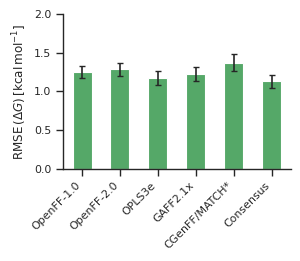

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(3.1,3))
statistic="RMSE"
ylabel=r"$\mathrm{" + statistic + "\,[kcal\,mol^{-1}]}$"
for name in ['ALL']:
    ddf = df_all.loc[np.invert(df_all['observed'].isna())]
    ddf = ddf.xs(name, level=1, axis=0)
    ddf = ddf.xs(statistic, level=1, axis=0)
    print(ddf)
    ddf.drop(["Consensus (OFF, GAFF)", "Consensus (all)"], axis=0, inplace=True)
    ddf.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
           "GAFF2": "GAFF2.1x",
           "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)  
    ddf["Forcefield"] = ddf.index
    g=sns.FacetGrid(ddf)
    g.map_dataframe(errplot, "Forcefield", "observed", "low", "high", capsize=2, color=sns.color_palette()[2])
#     sns.barplot(x = ddf.index,
#                 y = ddf['observed'],
#                )
#                 error_y=dict(
#             type='data',
#             symmetric=False,
#             array=ddf['high']-ddf['observed'],
#             arrayminus=ddf['observed']-ddf['low']
#             ),
#             name=name
#         )
#     )
plt.ylim(0.0, 2)
plt.xticks(rotation=45, ha='right')
plt.ylabel(r"$\mathrm{RMSE}\,(\Delta G)\,[\mathrm{kcal}\,\mathrm{mol}^{-1}]$")
plt.xlabel("")
plt.savefig(f"04b_bar_dg_RMSE_ff_all.png", bbox_inches="tight", dpi=1200)

                    mle  observed    stderr      mean       low      high  \
FF                                                                          
OpenFF-1.0     0.522898  0.522072  0.019215  0.521250  0.481246  0.558895   
OpenFF-2.0     0.552752  0.549695  0.017898  0.549931  0.515074  0.585438   
OPLS3e         0.602084  0.597577  0.017081  0.596972  0.563416  0.631325   
GAFF2.1x       0.555326  0.555430  0.018435  0.554803  0.516839  0.588526   
CGenFF/MATCH*  0.511799  0.503518  0.020233  0.503786  0.463114  0.541116   
Consensus      0.582287  0.580696  0.016548  0.581801  0.547549  0.614759   

                          string     Forcefield  
FF                                               
OpenFF-1.0     $0.5^{0.5}_{0.6}$     OpenFF-1.0  
OpenFF-2.0     $0.6^{0.5}_{0.6}$     OpenFF-2.0  
OPLS3e         $0.6^{0.6}_{0.6}$         OPLS3e  
GAFF2.1x       $0.6^{0.5}_{0.6}$       GAFF2.1x  
CGenFF/MATCH*  $0.5^{0.5}_{0.5}$  CGenFF/MATCH*  
Consensus      $0.6^{0.5}_{0.6}$ 

<Figure size 310x300 with 0 Axes>

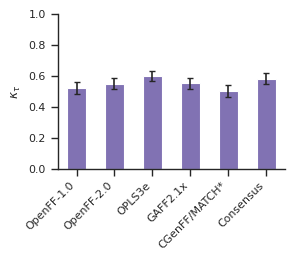

In [18]:
num_colors = 2
colors = ['white', sns.color_palette()[4]]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)

sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(3.1,3))
statistic="KTAU"
for name in ['ALL']:
    ddf = df_all.loc[np.invert(df_all['observed'].isna())]
    ddf = ddf.xs(name, level=1, axis=0)
    ddf = ddf.xs(statistic, level=1, axis=0)
    ddf.drop(["Consensus (OFF, GAFF)", "Consensus (all)"], axis=0, inplace=True)
    ddf["Forcefield"] = ddf.index
    print(ddf)
    g=sns.FacetGrid(ddf)
    g.map_dataframe(errplot, "Forcefield", "observed", "low", "high", capsize=2, color=sns.color_palette()[4])
#     sns.barplot(x = ddf.index,
#                 y = ddf['observed'],
#                )
#                 error_y=dict(
#             type='data',
#             symmetric=False,
#             array=ddf['high']-ddf['observed'],
#             arrayminus=ddf['observed']-ddf['low']
#             ),
#             name=name
#         )
#     )
plt.ylim(0.0, 1)
plt.xticks(rotation=45, ha='right')
plt.ylabel(r"$\kappa_{\tau}$")
plt.xlabel("")
plt.savefig(f"04b_bar_dg_KTAU_ff_all.png", bbox_inches="tight", dpi=1200)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
identifiers = [
    'OpenFF-1.0',
    'OpenFF-2.0',
    'OPLS3e',
    'GAFF2',
    'cGenFF', 
    'Consensus_OpenFF_GAFF2_cGenFF',
]

signif = {idx: {idx: np.nan for idx in identifiers} for idx in identifiers}
diffs = {idx: {} for idx in identifiers}
for i in range(len(identifiers)):
    for j in range(i+1, len(identifiers)):
        idx = identifiers[i]
        jdx = identifiers[j]
        ligands_df = all_ligands[['ligand', 'target', f'DG_Exp.', f'dDG_Exp.'] + [f'DG_{i}' for i in [idx,jdx]] + [f'dDG_{i}' for i in [idx,jdx]]]
        ligands_df = ligands_df[~ligands_df.isna().any(axis=1)]
        bSignif, diff = get_significance( ligands_df[f'DG_Exp.'].values, 
                         ligands_df[f'DG_{idx}'].values, 
                         ligands_df[f'DG_{jdx}'].values,
                         alpha=0.05, bootnum=1000, bReturnDiff=True )
        signif[idx][jdx]=int(bSignif)
        signif[jdx][idx]=int(bSignif)
#         signif[jdx][idx]=int(bSignif)
        diffs[idx][jdx]=diff
signif_df = pd.DataFrame(signif)
signif_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2,cGenFF,Consensus_OpenFF_GAFF2_cGenFF
OpenFF-1.0,NaN,0.0,0.0,0.0,1.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,0.0,1.0
OPLS3e,0.0,1.0,NaN,0.0,1.0,0.0
GAFF2,0.0,0.0,0.0,NaN,1.0,1.0
cGenFF,1.0,0.0,1.0,1.0,NaN,1.0
Consensus_OpenFF_GAFF2_cGenFF,1.0,1.0,0.0,1.0,1.0,NaN


In [21]:
signif_df = pd.DataFrame(signif)
signif_df.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
           "GAFF2": "GAFF2.1x",
           "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)  
signif_df.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
           "GAFF2": "GAFF2.1x",
           "cGenFF": "CGenFF/MATCH*"}, axis=1, inplace=True) 
signif_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2.1x,CGenFF/MATCH*,Consensus
OpenFF-1.0,NaN,0.0,0.0,0.0,1.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,0.0,1.0
OPLS3e,0.0,1.0,NaN,0.0,1.0,0.0
GAFF2.1x,0.0,0.0,0.0,NaN,1.0,1.0
CGenFF/MATCH*,1.0,0.0,1.0,1.0,NaN,1.0
Consensus,1.0,1.0,0.0,1.0,1.0,NaN


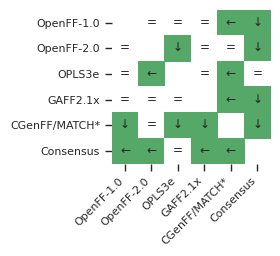

In [22]:
num_colors = 2
colors = ['white', sns.color_palette()[2]]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)

sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(2.05,2.0))
sns.heatmap(signif_df, vmin=0.0, vmax=1.0,cmap=cmap, cbar=False)#, cbar_kws={"ticks":[0,1.]})
plt.xticks(rotation=45, ha='right')
ax=plt.gca()
for ii, (i, row) in enumerate(signif_df.iterrows()):
    for jj, (j, item) in enumerate(row.iteritems()):
        if not np.isnan(item):
            if item:
                if df_all.loc[(i, "ALL", "RMSE"), "observed"] < df_all.loc[(j, "ALL", "RMSE"), "observed"]:
                    ax.text(jj+.5, ii+.5, "←", 
                            horizontalalignment='center',
                            verticalalignment='center')
                else:
                    ax.text(jj+.5, ii+.5, "↓", 
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.text(jj+.5, ii+.5, "=", 
                        horizontalalignment='center',
                        verticalalignment='center')
#cax = plt.gcf().axes[1]
#cax.set_ylim(0,1)
#cax.set_yticklabels(["NS", "*"])
plt.savefig("04b_heatmap_dg_rmse_significance.png",bbox_inches="tight", dpi=1200)

In [23]:
identifiers = [
    'OpenFF-1.0',
    'OpenFF-2.0',
    'OPLS3e',
    'GAFF2',
    'cGenFF', 
    'Consensus_OpenFF_GAFF2_cGenFF',
]

signif = {idx: {idx: np.nan for idx in identifiers} for idx in identifiers}
diffs = {idx: {} for idx in identifiers}
for i in range(len(identifiers)):
    for j in range(i+1, len(identifiers)):
        idx = identifiers[i]
        jdx = identifiers[j]
        ligands_df = all_ligands[['ligand', 'target', f'DG_Exp.', f'dDG_Exp.'] + [f'DG_{i}' for i in [idx,jdx]] + [f'dDG_{i}' for i in [idx,jdx]]]
        ligands_df = ligands_df[~ligands_df.isna().any(axis=1)]
        bSignif, diff = get_significance_ktau(ligands_df[f'DG_Exp.'].values, 
                         ligands_df[f'DG_{idx}'].values, 
                         ligands_df[f'DG_{jdx}'].values,
                         alpha=0.05, bootnum=1000, bReturnDiff=True )
        signif[idx][jdx]=int(bSignif)
        signif[jdx][idx]=int(bSignif)
#         signif[jdx][idx]=int(bSignif)
        diffs[idx][jdx]=diff
signif_ktau_df = pd.DataFrame(signif)
signif_ktau_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2,cGenFF,Consensus_OpenFF_GAFF2_cGenFF
OpenFF-1.0,NaN,0.0,1.0,1.0,0.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,1.0,1.0
OPLS3e,1.0,1.0,NaN,1.0,1.0,0.0
GAFF2,1.0,0.0,1.0,NaN,1.0,0.0
cGenFF,0.0,1.0,1.0,1.0,NaN,1.0
Consensus_OpenFF_GAFF2_cGenFF,1.0,1.0,0.0,0.0,1.0,NaN


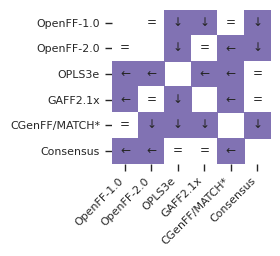

In [24]:
num_colors = 2
colors = ['white', sns.color_palette()[4]]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)


signif_ktau_df.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
               "GAFF2": "GAFF2.1x",
               "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)
signif_ktau_df.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
               "GAFF2": "GAFF2.1x",
               "cGenFF": "CGenFF/MATCH*"}, axis=1, inplace=True)
sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(2.05, 2))
sns.heatmap(signif_ktau_df, vmin=0.0, vmax=1.0, cmap=cmap, cbar=False)#, cbar_kws={"ticks":[0,1.]})
plt.xticks(rotation=45, ha='right')
ax=plt.gca()
for ii, (i, row) in enumerate(signif_ktau_df.iterrows()):
    for jj, (j, item) in enumerate(row.iteritems()):
        if not np.isnan(item):
            if item:
                if df_all.loc[(i, "ALL", "RMSE"), "observed"] < df_all.loc[(j, "ALL", "RMSE"), "observed"]:
                    ax.text(jj+.5, ii+.5, "←", 
                                horizontalalignment='center',
                            verticalalignment='center')
                else:
                    ax.text(jj+.5, ii+.5, "↓", 
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.text(jj+.5, ii+.5, "=", 
                        horizontalalignment='center',
                        verticalalignment='center')
plt.savefig("04b_heatmap_dg_ktau_significance.png",bbox_inches="tight", dpi=1200)

                            mle  observed    stderr      mean       low  \
FF                                                                        
OpenFF-1.0             1.253905  1.249489  0.039458  1.249313  1.175213   
OpenFF-2.0             1.282147  1.285022  0.043875  1.285027  1.200331   
OPLS3e                 1.152907  1.174216  0.045630  1.172098  1.082425   
GAFF2.1x               1.229357  1.223997  0.048398  1.221397  1.125943   
CGenFF/MATCH*          1.376926  1.370467  0.053565  1.370142  1.262491   
Consensus              1.129541  1.131984  0.043164  1.130493  1.047384   
Consensus (OFF, GAFF)  1.237348  1.235653  0.044236  1.238074  1.152475   
Consensus (all)        1.003420  1.014257  0.036457  1.012531  0.940602   

                           high             string  
FF                                                  
OpenFF-1.0             1.327150  $1.3^{1.2}_{1.3}$  
OpenFF-2.0             1.369707  $1.3^{1.2}_{1.4}$  
OPLS3e                 1.263968  $1.2

<Figure size 310x300 with 0 Axes>

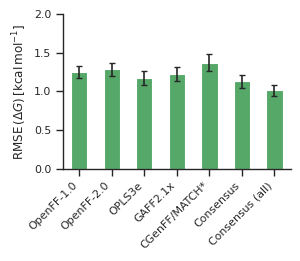

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(3.1,3))
statistic="RMSE"
ylabel=r"$\mathrm{" + statistic + "\,[kcal\,mol^{-1}]}$"
for name in ['ALL']:
    ddf = df_all.loc[np.invert(df_all['observed'].isna())]
    ddf = ddf.xs(name, level=1, axis=0)
    ddf = ddf.xs(statistic, level=1, axis=0)
    print(ddf)
    ddf.drop(["Consensus (OFF, GAFF)"], axis=0, inplace=True)
    ddf.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
               "GAFF2": "GAFF2.1x",
               "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)
    ddf["Forcefield"] = ddf.index
    g=sns.FacetGrid(ddf)
    g.map_dataframe(errplot, "Forcefield", "observed", "low", "high", capsize=2, color=sns.color_palette()[2])
plt.ylim(0.0, 2)
plt.xticks(rotation=45, ha='right')
plt.ylabel(r"$\mathrm{RMSE}\,(\Delta G)\,[\mathrm{kcal}\,\mathrm{mol}^{-1}]$")
plt.xlabel("")
plt.savefig(f"04b_bar_dg_RMSE_ff_all_consensus.png", bbox_inches="tight", dpi=1200)

<Figure size 310x300 with 0 Axes>

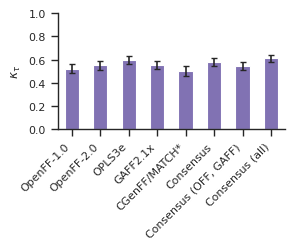

In [26]:
sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(3.1,3))
statistic="KTAU"
for name in ['ALL']:
    ddf = df_all.loc[np.invert(df_all['observed'].isna())]
    ddf = ddf.xs(name, level=1, axis=0)
    ddf = ddf.xs(statistic, level=1, axis=0)
    ddf.rename({"Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
               "GAFF2": "GAFF2.1x",
               "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)
    ddf["Forcefield"] = ddf.index
    g=sns.FacetGrid(ddf)
    g.map_dataframe(errplot, "Forcefield", "observed", "low", "high", capsize=2, color=sns.color_palette()[4])
plt.ylim(0.0, 1)
plt.xticks(rotation=45, ha='right')
plt.ylabel(r"$\kappa_{\tau}$")
plt.xlabel("")
plt.savefig(f"04b_bar_dg_KTAU_ff_all_consensus.png", bbox_inches="tight", dpi=1200)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
identifiers = [
    'OpenFF-1.0',
    'OpenFF-2.0',
    'OPLS3e',
    'GAFF2',
    'cGenFF', 
    'Consensus_OpenFF_GAFF2_cGenFF',
    'Consensus_OpenFF_GAFF2',
    'Consensus_all'
]

signif = {idx: {idx: np.nan for idx in identifiers} for idx in identifiers}
diffs = {idx: {} for idx in identifiers}
for i in range(len(identifiers)):
    for j in range(i+1, len(identifiers)):
        idx = identifiers[i]
        jdx = identifiers[j]
        ligands_df = all_ligands[['ligand', 'target', f'DG_Exp.', f'dDG_Exp.'] + [f'DG_{i}' for i in [idx,jdx]] + [f'dDG_{i}' for i in [idx,jdx]]]
        ligands_df = ligands_df[~ligands_df.isna().any(axis=1)]
        bSignif, diff = get_significance( ligands_df[f'DG_Exp.'].values, 
                         ligands_df[f'DG_{idx}'].values, 
                         ligands_df[f'DG_{jdx}'].values,
                         alpha=0.05, bootnum=1000, bReturnDiff=True )
        signif[idx][jdx]=int(bSignif)
        signif[jdx][idx]=int(bSignif)
#         signif[jdx][idx]=int(bSignif)
        diffs[idx][jdx]=diff
signif_df = pd.DataFrame(signif)
signif_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2,cGenFF,Consensus_OpenFF_GAFF2_cGenFF,Consensus_OpenFF_GAFF2,Consensus_all
OpenFF-1.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0
OPLS3e,0.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0
GAFF2,0.0,0.0,0.0,NaN,1.0,1.0,0.0,1.0
cGenFF,1.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0
Consensus_OpenFF_GAFF2_cGenFF,1.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0
Consensus_OpenFF_GAFF2,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
Consensus_all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [29]:
signif_df = pd.DataFrame(signif)
signif_df.rename({
    "Consensus_all": "Consensus (all)",
    'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)",
    "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
    "GAFF2": "GAFF2.1x",
    "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)
signif_df.rename({
    "Consensus_all": "Consensus (all)",
    'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)",
    "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
    "GAFF2": "GAFF2.1x",
    "cGenFF": "CGenFF/MATCH*"}, axis=1, inplace=True)
signif_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2.1x,CGenFF/MATCH*,Consensus,"Consensus (OFF, GAFF)",Consensus (all)
OpenFF-1.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0
OPLS3e,0.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0
GAFF2.1x,0.0,0.0,0.0,NaN,1.0,1.0,0.0,1.0
CGenFF/MATCH*,1.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0
Consensus,1.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0
"Consensus (OFF, GAFF)",0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
Consensus (all),1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


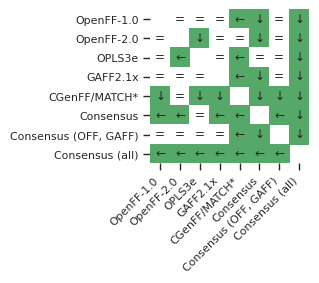

In [30]:
num_colors = 2
colors = ['white', sns.color_palette()[2]]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)

sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(2.05,2))
sns.heatmap(signif_df, vmin=0.0, vmax=1.0,cmap=cmap, cbar=False)#, cbar_kws={"ticks":[0,1.]})
plt.xticks(rotation=45, ha='right')
ax=plt.gca()
for ii, (i, row) in enumerate(signif_df.iterrows()):
    for jj, (j, item) in enumerate(row.iteritems()):
        if not np.isnan(item):
            if item:
                if df_all.loc[(i, "ALL", "RMSE"), "observed"] < df_all.loc[(j, "ALL", "RMSE"), "observed"]:
                    ax.text(jj+.5, ii+.5, "←", 
                            horizontalalignment='center',
                            verticalalignment='center')
                else:
                    ax.text(jj+.5, ii+.5, "↓", 
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.text(jj+.5, ii+.5, "=", 
                        horizontalalignment='center',
                        verticalalignment='center')
#cax = plt.gcf().axes[1]
#cax.set_ylim(0,1)
#cax.set_yticklabels(["NS", "*"])
plt.savefig("04b_heatmap_dg_rmse_significance_consensus.png",bbox_inches="tight", dpi=1200)

In [31]:
identifiers = [
    'OpenFF-1.0',
    'OpenFF-2.0',
    'OPLS3e',
    'GAFF2',
    'cGenFF', 
    'Consensus_OpenFF_GAFF2_cGenFF',
    'Consensus_OpenFF_GAFF2',
    'Consensus_all'
]

signif = {idx: {idx: np.nan for idx in identifiers} for idx in identifiers}
diffs = {idx: {} for idx in identifiers}
for i in range(len(identifiers)):
    for j in range(i+1, len(identifiers)):
        idx = identifiers[i]
        jdx = identifiers[j]
        ligands_df = all_ligands[['ligand', 'target', f'DG_Exp.', f'dDG_Exp.'] + [f'DG_{i}' for i in [idx,jdx]] + [f'dDG_{i}' for i in [idx,jdx]]]
        ligands_df = ligands_df[~ligands_df.isna().any(axis=1)]
        bSignif, diff = get_significance_ktau(ligands_df[f'DG_Exp.'].values, 
                         ligands_df[f'DG_{idx}'].values, 
                         ligands_df[f'DG_{jdx}'].values,
                         alpha=0.05, bootnum=1000, bReturnDiff=True )
        signif[idx][jdx]=int(bSignif)
        signif[jdx][idx]=int(bSignif)
#         signif[jdx][idx]=int(bSignif)
        diffs[idx][jdx]=diff
signif_ktau_df = pd.DataFrame(signif)
signif_ktau_df

,OpenFF-1.0,OpenFF-2.0,OPLS3e,GAFF2,cGenFF,Consensus_OpenFF_GAFF2_cGenFF,Consensus_OpenFF_GAFF2,Consensus_all
OpenFF-1.0,NaN,0.0,1.0,1.0,0.0,1.0,0.0,1.0
OpenFF-2.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0
OPLS3e,1.0,1.0,NaN,1.0,1.0,0.0,1.0,0.0
GAFF2,1.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0
cGenFF,0.0,1.0,1.0,1.0,NaN,1.0,0.0,1.0
Consensus_OpenFF_GAFF2_cGenFF,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0
Consensus_OpenFF_GAFF2,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0
Consensus_all,1.0,1.0,0.0,1.0,1.0,1.0,1.0,NaN


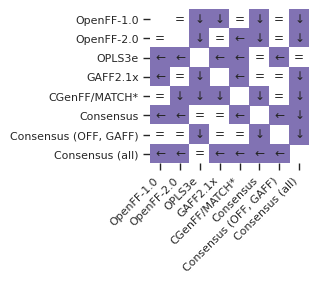

In [32]:
num_colors = 2
colors = ['white', sns.color_palette()[4]]
cmap = LinearSegmentedColormap.from_list('', colors, num_colors)

signif_ktau_df.rename({
    "Consensus_all": "Consensus (all)",
    "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
    'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)",
    "GAFF2": "GAFF2.1x",
    "cGenFF": "CGenFF/MATCH*"}, axis=0, inplace=True)
signif_ktau_df.rename({
    "Consensus_all": "Consensus (all)",
    "Consensus_OpenFF_GAFF2_cGenFF": "Consensus", 
    'Consensus_OpenFF_GAFF2': "Consensus (OFF, GAFF)",
    "GAFF2": "GAFF2.1x",
    "cGenFF": "CGenFF/MATCH*"}, axis=1, inplace=True)
sns.set(style="ticks", rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=0.9)
fig = plt.figure(figsize=(2.05,2))
sns.heatmap(signif_ktau_df, vmin=0.0, vmax=1.0,cmap=cmap, cbar=False)#, cbar_kws={"ticks":[0,1.]})
plt.xticks(rotation=45, ha='right')
ax=plt.gca()
for ii, (i, row) in enumerate(signif_ktau_df.iterrows()):
    for jj, (j, item) in enumerate(row.iteritems()):
        if not np.isnan(item):
            if item:
                if df_all.loc[(i, "ALL", "RMSE"), "observed"] < df_all.loc[(j, "ALL", "RMSE"), "observed"]:
                    ax.text(jj+.5, ii+.5, "←", 
                            horizontalalignment='center',
                            verticalalignment='center')
                else:
                    ax.text(jj+.5, ii+.5, "↓", 
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.text(jj+.5, ii+.5, "=", 
                        horizontalalignment='center',
                        verticalalignment='center')
#cax = plt.gcf().axes[1]
#cax.set_ylim(0,1)
#cax.set_yticklabels(["NS", "*"])
plt.savefig("04b_heatmap_dg_ktau_significance_consensus.png",bbox_inches="tight", dpi=1200)